---
title: Three High-Dimensional Models
---

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import cvxpy as cp
import yfinance as yf
import mosek

We will use the cvxpy library for computing estimates in this  lecture. cvxpy allows the use of many solvers. We shall use here the solver coming from the library 'mosek'. Mosek is a commercial solver for convex optimization. I will use "solver = MOSEK" in the convex optimization schemes below for computing estimators. Mosek is more reliable than the other solvers that cvxpy uses. To use MOSEK, you first have to install it in your python environment (e.g., using "pip install mosek" or "conda install -c conda-forge mosek"), then you need to request a personal mosek academic license (at this address: https://www.mosek.com/products/academic-licenses/ by using your email address). The license will be emailed to you. You need to download the license file and place it in the correct directory (this information is given in the license email). After this, the mosek solver should work in cvxpy. 

We shall discuss three simple high-dimensional models for time series. The first model coincides with the high-dimensional linear regression model from the previous few lectures. The second model is a variance model that was briefly introduced near the end of the last lecture. The third model is a variance model in terms of the DFT (it will be referred to as the spectrum model). 

## Model ONE

This is the model
\begin{equation*}
   y_t \overset{\text{ind}}{\sim} N(\mu_t, \sigma^2)
\end{equation*}
where $\mu_t$ (which can be interpreted as the trend function) is smooth in $t$. $\mu_t$ can be estimated from the data using one of the following two regularized estimators obtained by minimizing
\begin{equation*}
   \sum_{t=1}^n (y_t - \mu_t)^2 + \lambda \sum_{t=2}^{n-1} \left((\mu_t - \mu_{t-1}) - (\mu_{t-1} - \mu_t) \right)^2
\end{equation*}
or
\begin{equation*}
   \sum_{t=1}^n (y_t - \mu_t)^2 + \lambda \sum_{t=2}^{n-1} \left|(\mu_t - \mu_{t-1}) - (\mu_{t-1} - \mu_t) \right|
\end{equation*}
As we saw previously, these are the same as the estimators obtained by employing the ridge and LASSO penalties to the high-dimensional linear regression model: 
\begin{equation*}
   \mu_t = \beta_0 + \beta_1 (t-1) + \beta_2 (t-2)_+ + \dots + \beta_{n-1} (t - (n-1))_+
\end{equation*}

Below is an application of this model to smooth trend estimation. We simulate data by adding noise to a smooth function, and then estimate it using one of the two estimators above. 

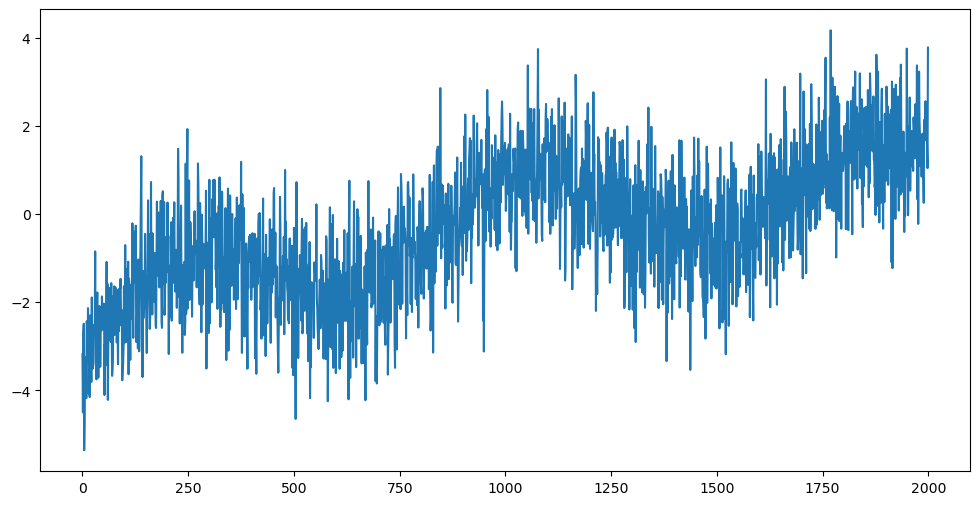

In [60]:
def smoothfun(x):
    ans = np.sin(15*x) + np.exp(-(x ** 2)/2) + 0.5*((x - 0.5) ** 2) + 2*np.log(x + 0.1)
    return ans

n = 2000
xx = np.linspace(0, 1, n)
mu_true = np.array([smoothfun(x) for x in xx])
sig = 1
rng = np.random.default_rng(seed = 42)
errorsamples = rng.normal(loc = 0, scale = sig, size = n)
y = mu_true + errorsamples
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.show()


Below we compute the estimator $\hat{\mu}_t$ directly without going to the regression representation (with the $X$ matrix that we previously used). We use the optimization functions from cvxpy directly on the optimization in terms of $\mu_t$.

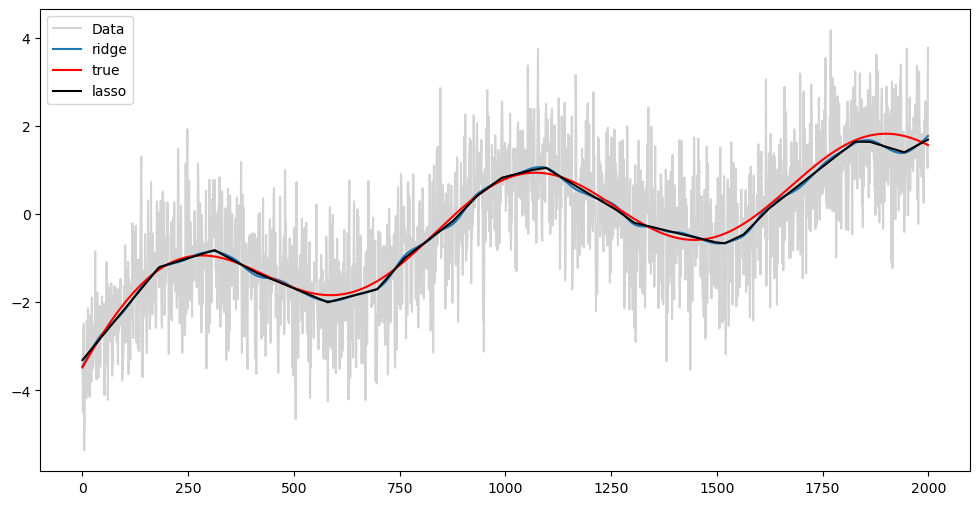

In [61]:
def mu_est_ridge(y, lambda_val):
    n = len(y)
    mu = cp.Variable(n)
    neg_likelihood_term = cp.sum((y - mu)**2)
    smoothness_penalty = cp.sum(cp.square(mu[2:] - 2 * mu[1:-1] + mu[:-2]))
    objective = cp.Minimize(neg_likelihood_term + lambda_val * smoothness_penalty)
    problem = cp.Problem(objective)
    problem.solve(solver = cp.MOSEK)
    return mu.value

def mu_est_lasso(y, lambda_val):
    n = len(y)
    mu = cp.Variable(n)
    neg_likelihood_term = cp.sum((y - mu)**2)
    smoothness_penalty = cp.sum(cp.abs(mu[2:] - 2 * mu[1:-1] + mu[:-2]))
    objective = cp.Minimize(neg_likelihood_term + lambda_val * smoothness_penalty)
    problem = cp.Problem(objective)
    problem.solve(solver = cp.MOSEK)
    return mu.value

mu_opt_ridge = mu_est_ridge(y, 200000)
mu_opt_lasso = mu_est_lasso(y, 200)
plt.figure(figsize = (12, 6))
plt.plot(y, label = 'Data', color = 'lightgray')
plt.plot(mu_opt_ridge, label = 'ridge')
plt.plot(mu_true, color = 'red', label = 'true') 
plt.plot(mu_opt_lasso, color = 'black', label = 'lasso')
plt.legend()
plt.show()

## Model TWO

This is the model 
\begin{equation*}
   y_t \overset{\text{independent}}{\sim} N(0, \tau_t^2) 
\end{equation*}
Negative log-likelihood parametrized by $\alpha_t = \log \tau_t$ is given by
\begin{equation*}
  \sum_{t=1}^n \left(\alpha_t + \frac{y_t^2}{2} e^{-2 \alpha_t} \right)
\end{equation*}
We add regularization and minimize: 
\begin{equation*}
  \sum_{t=1}^n \left(\alpha_t + \frac{y_t^2}{2} e^{-2 \alpha_t} \right) + \lambda \sum_{t=2}^{n-1} \left((\alpha_{t+1} - \alpha_{t})- (\alpha_{t} - \alpha_{t-1})\right)^2
\end{equation*}
or
\begin{equation*}
  \sum_{t=1}^n \left(\alpha_t + \frac{y_t^2}{2} e^{-2 \alpha_t} \right) + \lambda \sum_{t=2}^{n-1} \left|(\alpha_{t+1} - \alpha_{t})- (\alpha_{t} - \alpha_{t-1})\right|
\end{equation*}

In [62]:
def alpha_est_ridge(y, lambda_val):
    n = len(y)
    alpha = cp.Variable(n)
    neg_likelihood_term = cp.sum(cp.multiply(((y ** 2)/2), cp.exp(-2 * alpha)) + alpha)
    smoothness_penalty = cp.sum(cp.square(alpha[2:] - 2 * alpha[1:-1] + alpha[:-2]))
    objective = cp.Minimize(neg_likelihood_term + lambda_val * smoothness_penalty)
    problem = cp.Problem(objective)
    problem.solve(solver = cp.MOSEK)
    return alpha.value

def alpha_est_lasso(y, lambda_val):
    n = len(y)
    alpha = cp.Variable(n)
    neg_likelihood_term = cp.sum(cp.multiply(((y ** 2)/2), cp.exp(-2 * alpha)) + alpha)
    smoothness_penalty = cp.sum(cp.abs(alpha[2:] - 2 * alpha[1:-1] + alpha[:-2]))
    objective = cp.Minimize(neg_likelihood_term + lambda_val * smoothness_penalty)
    problem = cp.Problem(objective)
    problem.solve(solver = cp.MOSEK)
    return alpha.value

Below we describe two simulation settings for this model. 

### Simulation 1 for Model 2

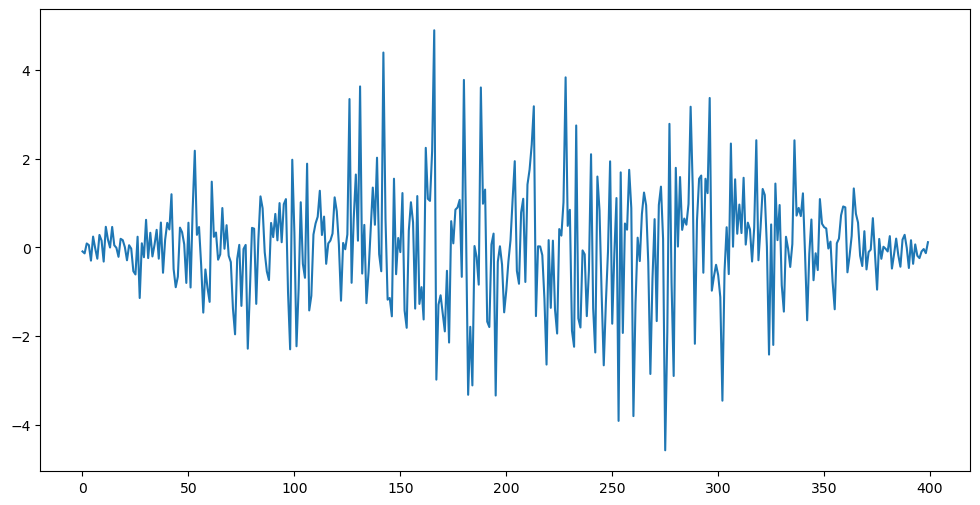

In [63]:
#Simulate data from this variance model:
n = 400
tvals = np.arange(1, n+1)
th = -0.8
tau_t = np.sqrt((1 + (th ** 2) + 2*th*np.cos(2 * np.pi * (tvals)/n))) #this is a smooth function of t
y = rng.normal(loc = 0, scale = tau_t)
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.show()

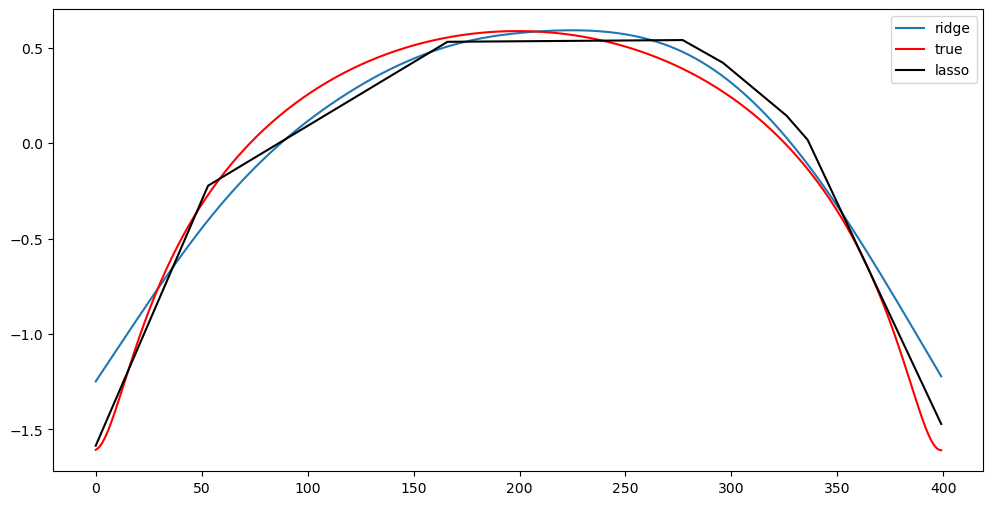

In [64]:
alpha_true = np.log(tau_t)
alpha_opt_ridge = alpha_est_ridge(y, 2000000)
alpha_opt_lasso = alpha_est_lasso(y, 200)
plt.figure(figsize = (12, 6))
plt.plot(alpha_opt_ridge, label = 'ridge')
plt.plot(alpha_true, color = 'red', label = 'true') 
plt.plot(alpha_opt_lasso, color = 'black', label = 'lasso')
plt.legend()
plt.show()

The sufficient statistic in this model is $y_1^2, \dots, y_n^2$. Because $y_t^2 \sim \tau_t^2 \chi^2_1$, the mean of $y_t^2$ equals $\tau_t^2$ and its variance is $2 \tau^4$. Below we plot $y_t^2$ as well as $\tau_t^2$.

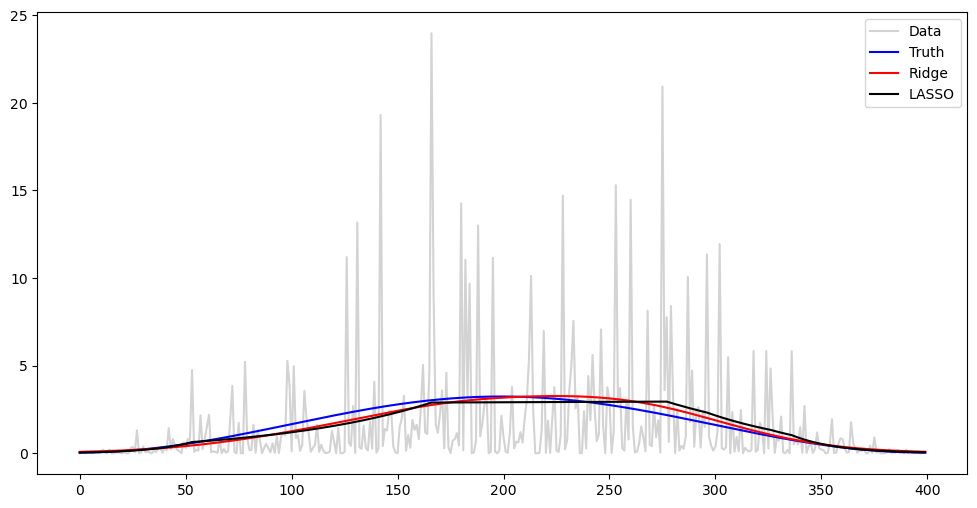

In [65]:
#Plotting y^2 against tau^2
plt.figure(figsize = (12, 6))
plt.plot(y ** 2, label = 'Data', color = 'lightgray')
plt.plot(tau_t ** 2, color = 'blue', label = 'Truth')
plt.plot(np.exp(2*alpha_opt_ridge), color = 'red', label = 'Ridge')
plt.plot(np.exp(2*alpha_opt_lasso), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

Observe from the above plot that both the level (mean) of $y_t^2$ as well as its variance changes with $\tau_t^2$. This is because the mean of $y_t^2$ equals $\tau_t^2$, and its variance equals $2 \tau_t^4$. 

Because $y_t^2 \sim \tau_t^2 \chi^2_1$, we can write
\begin{equation*}
   \log(y_t^2) = \log(\tau_t^2) + \log (\chi^2_1)
\end{equation*}
The mean of $\log \chi^2_1$ is negative (internet says it is about -1.27). This means that if we plot $\log y_t^2$ and $\log \tau_t^2$ in one figure, most of the values for $\log y_t^2$ will appear to be below $\log \tau_t^2$. 

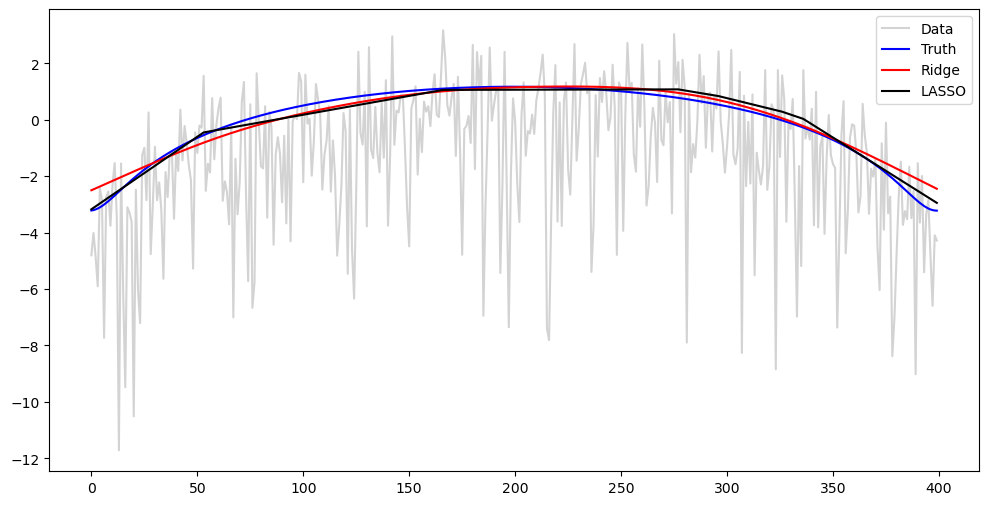

In [66]:
#Plotting log y^2 against log tau^2
plt.figure(figsize = (12, 6))
plt.plot(np.log(y ** 2), color = 'lightgray', label = 'Data')
plt.plot(np.log(tau_t ** 2), color = 'blue', label = 'Truth')
plt.plot(np.log(np.exp(2*alpha_opt_ridge)), color = 'red', label = 'Ridge')
plt.plot(np.log(np.exp(2*alpha_opt_lasso)), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

### Simulation 2 for Model 2

Here is the second simulation setting for this model. 

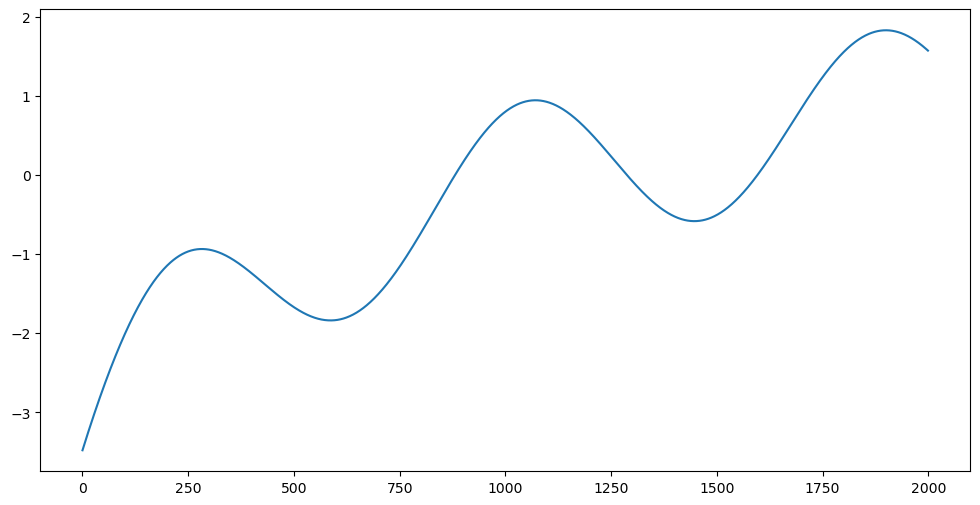

In [67]:
def smoothfun(x):
    ans = np.sin(15*x) + np.exp(-(x ** 2)/2) + 0.5*((x - 0.5) ** 2) + 2*np.log(x + 0.1)
    return ans

n = 2000
xx = np.linspace(0, 1, n)
alpha_true = np.array([smoothfun(x) for x in xx])
plt.figure(figsize = (12, 6))
plt.plot(alpha_true)
plt.show()

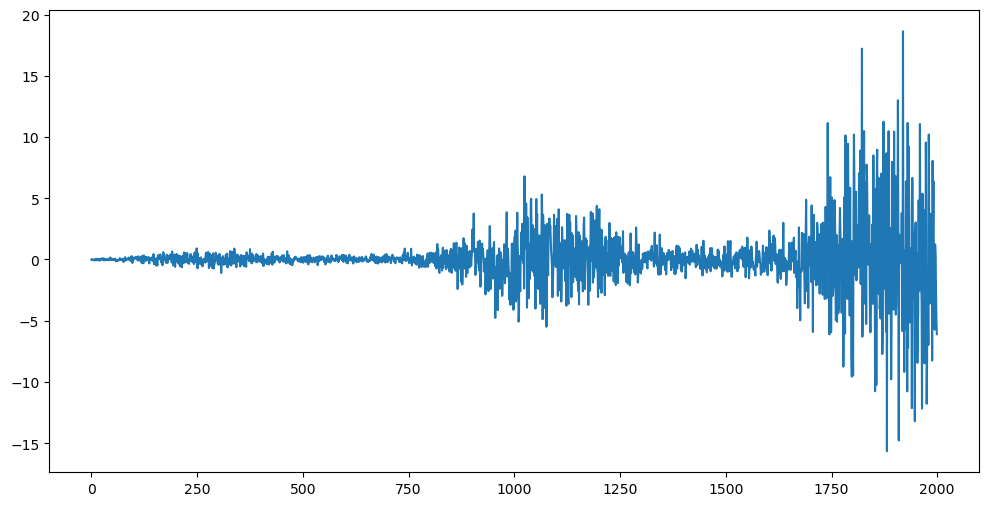

In [68]:
tau_t = np.exp(alpha_true)
y = rng.normal(loc = 0, scale = tau_t)
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.show()

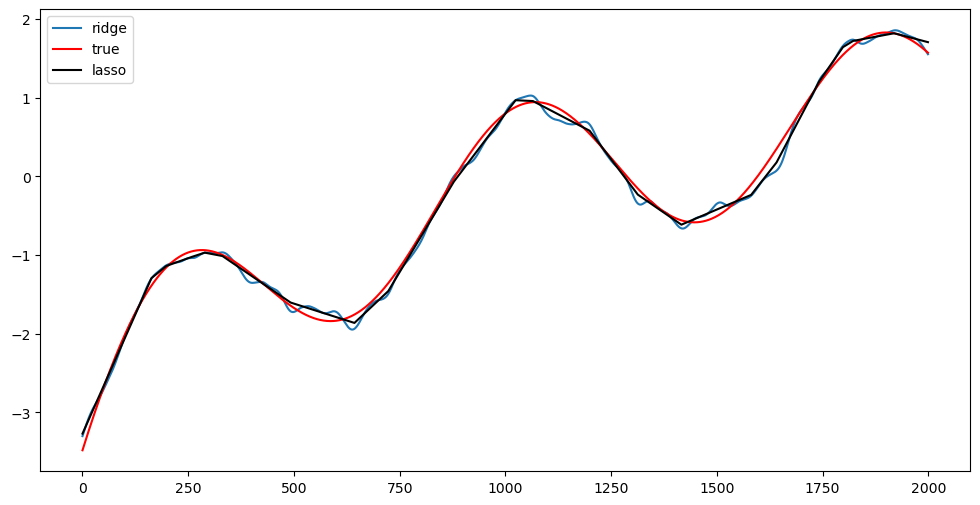

In [69]:
alpha_opt_ridge = alpha_est_ridge(y, 40000)
alpha_opt_lasso = alpha_est_lasso(y, 200)
plt.figure(figsize = (12, 6))
plt.plot(alpha_opt_ridge, label = 'ridge')
plt.plot(alpha_true, color = 'red', label = 'true') 
plt.plot(alpha_opt_lasso, color = 'black', label = 'lasso')
plt.legend()
plt.show()

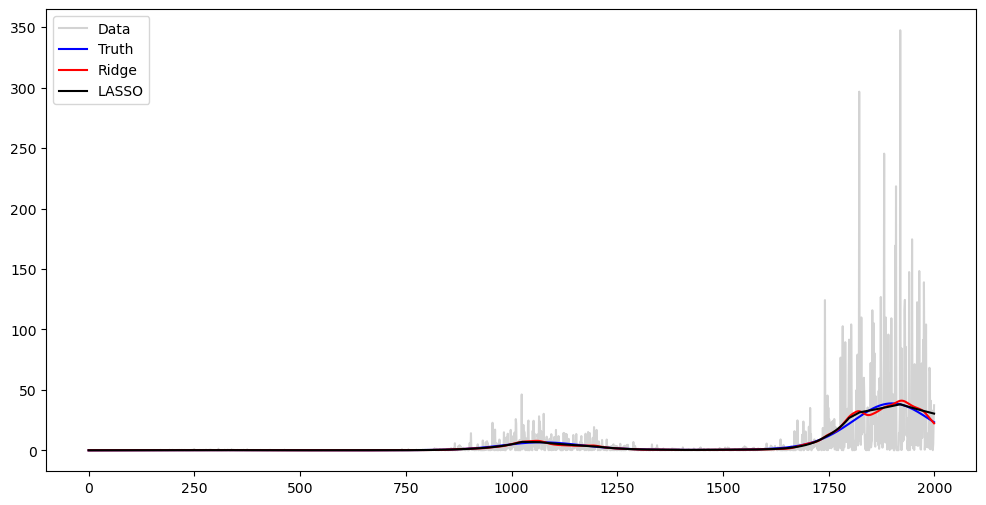

In [70]:
#Plotting y^2 against tau^2
plt.figure(figsize = (12, 6))
plt.plot(y ** 2, label = 'Data', color = 'lightgray')
plt.plot(tau_t ** 2, color = 'blue', label = 'Truth')
plt.plot(np.exp(2*alpha_opt_ridge), color = 'red', label = 'Ridge')
plt.plot(np.exp(2*alpha_opt_lasso), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

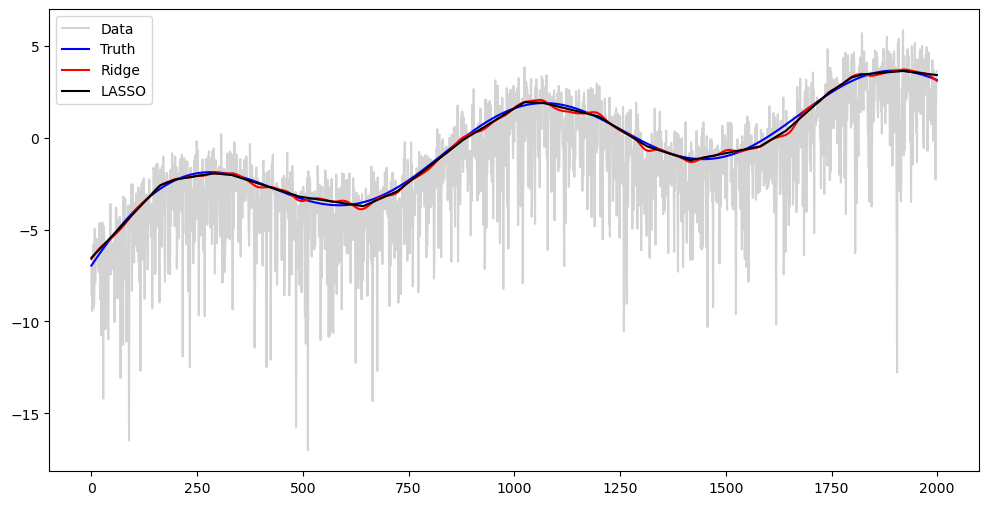

In [71]:
#Plotting log y^2 against log tau^2
plt.figure(figsize = (12, 6))
plt.plot(np.log(y ** 2), color = 'lightgray', label = 'Data')
plt.plot(np.log(tau_t ** 2), color = 'blue', label = 'Truth')
plt.plot(np.log(np.exp(2*alpha_opt_ridge)), color = 'red', label = 'Ridge')
plt.plot(np.log(np.exp(2*alpha_opt_lasso)), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

### A real dataset from finance for which Model 2 is applicable

Next, we examine a real dataset where this variance model (Model 2) may be applicable. The dataset consists of stock price data for the S&P 500 mutual fund, downloaded from Yahoo Finance using the yfinance library.

[*********************100%***********************]  1 of 1 completed


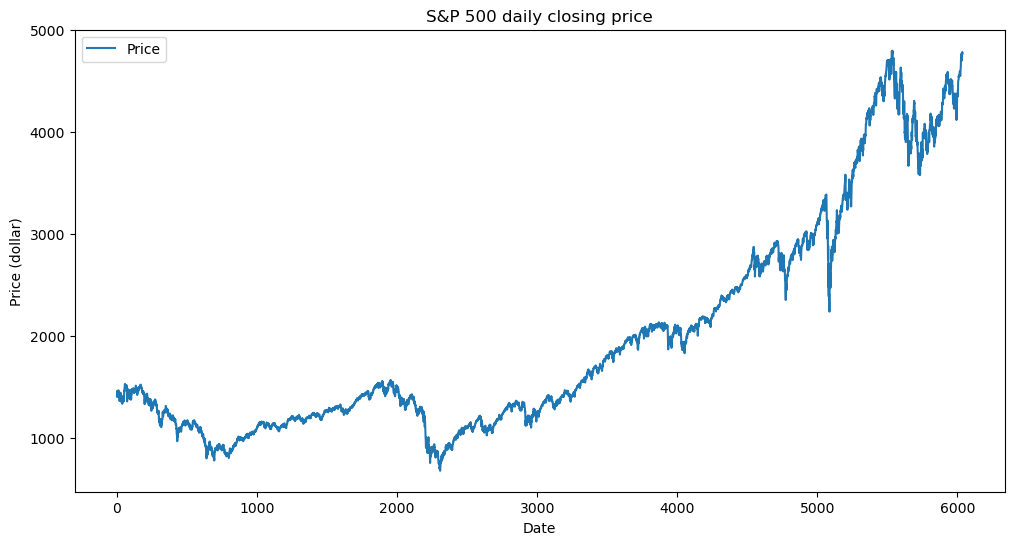

In [72]:
# Download S&P 500 data
sp500 = yf.download('^GSPC', start='2000-01-01', end='2024-01-01', auto_adjust = True)

sp500_closeprice = sp500['Close'].to_numpy().flatten() #this is the daily closing price of the S&P 500 index

plt.figure(figsize=(12,6))
plt.plot(sp500_closeprice, label="Price")
plt.xlabel("Date")
plt.title("S&P 500 daily closing price")
plt.ylabel("Price (dollar)")
plt.legend()
plt.show()


Instead of working with the prices directly, we work with percentage daily returns. 

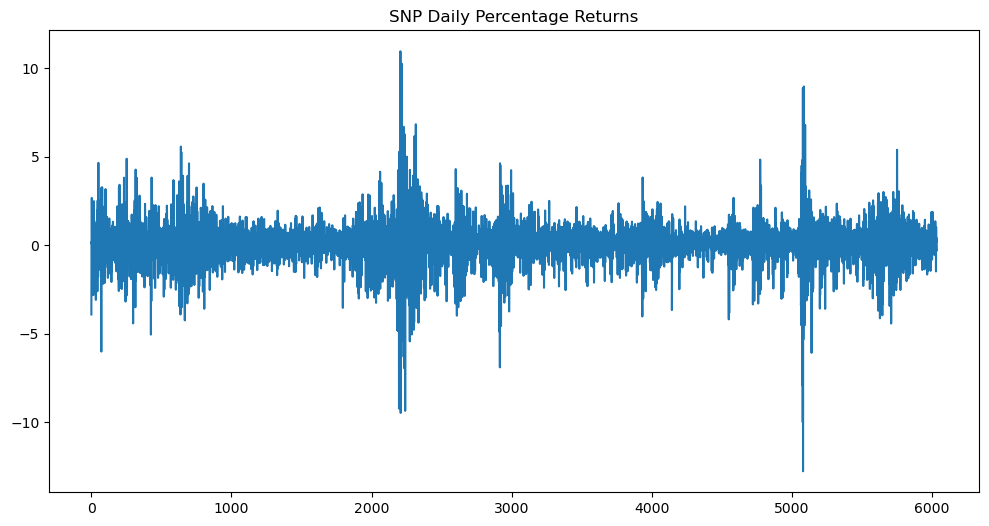

In [73]:
log_prices = np.log(sp500_closeprice)
y = 100 * np.diff(log_prices) #these are the percentage daily returns
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.title('SNP Daily Percentage Returns')
plt.show()

The plot above suggests that Model 2 might be useful for this dataset. 

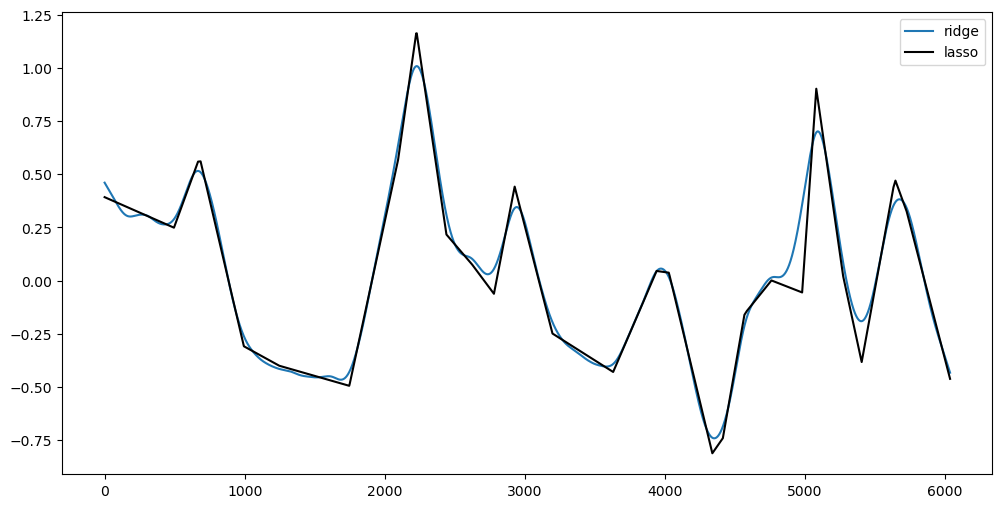

In [74]:
alpha_opt_ridge = alpha_est_ridge(y, 40000000)
alpha_opt_lasso = alpha_est_lasso(y, 2000)
plt.figure(figsize = (12, 6))
plt.plot(alpha_opt_ridge, label = 'ridge')
plt.plot(alpha_opt_lasso, color = 'black', label = 'lasso')
plt.legend()
plt.show()

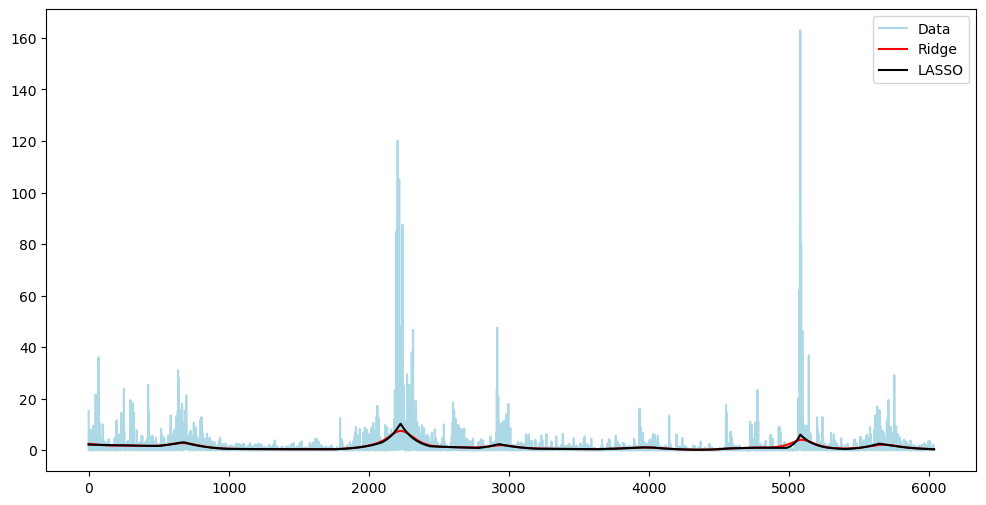

In [75]:
#Plotting y^2 against tau^2
plt.figure(figsize = (12, 6))
plt.plot(y ** 2, label = 'Data', color = 'lightblue')
plt.plot(np.exp(2*alpha_opt_ridge), color = 'red', label = 'Ridge')
plt.plot(np.exp(2*alpha_opt_lasso), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

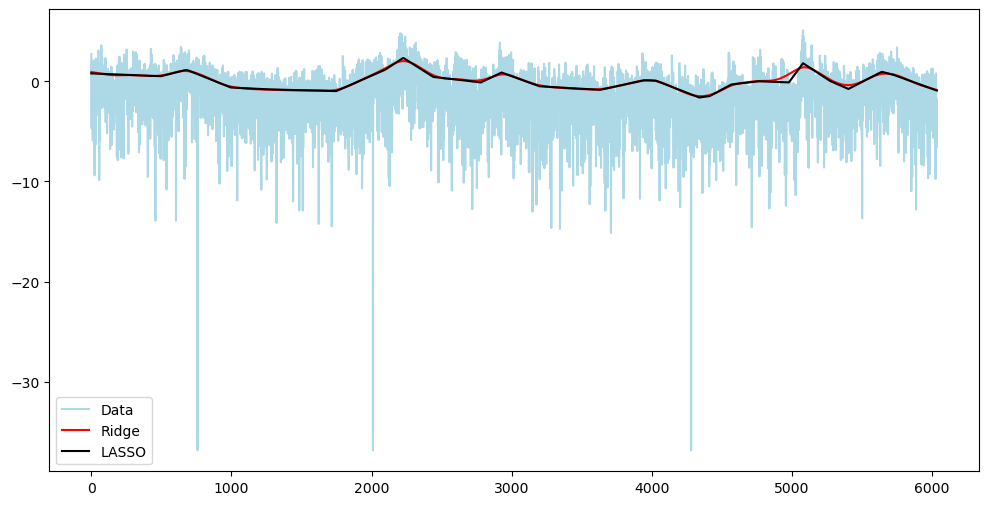

In [76]:
#Plotting log y^2 against log tau^2
plt.figure(figsize = (12, 6))
plt.plot(2*np.log(np.abs(y) + 1e-8), color = 'lightblue', label = 'Data') #small value added to np.abs(y) to prevent taking logs of zeros
plt.plot(np.log(np.exp(2*alpha_opt_ridge)), color = 'red', label = 'Ridge')
plt.plot(np.log(np.exp(2*alpha_opt_lasso)), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

## Model THREE

We shall discuss a third model which is related to the previous two but is much more popular in many sciences and engineering. We shall refer to as the spectrum model. It is simply the variance model applied to the Discrete Fourier Transform (DFT) of the data. Before writing down the model, here is a motivating example. 

### EEG Motor Movement Dataset

The following dataset was downloaded from https://physionet.org/content/eegmmidb/1.0.0/. The specific dataset details are here: https://physionet.org/content/eegmmidb/1.0.0/. The dataset consists of over 1500 one and two minute (64 channel) EEG recordings, obtained from 109 volunteers. We will pick data for just one subject (volunteer) and one of the EEG channels, and compare the data for eyes open vs eyes closed. A basic finding of cognitive neuroscience is that the power of occipital alpha-band (~10 Hz) brain waves is increased when peoples' eyes are closed, rather than open (see, for example, the paper titled "Occipital alpha-band brain waves when the eyes are closed are shaped by ongoing visual processes" by Hohaia et al 2022). 

The mne python library is necessary for loading the data file. 

In [77]:
import mne

For each individual subject (here we are using the data for the first subject), there are 64 time series datasets for "open-eyes" and again 64 time series datasets for "closed-eyes". These 64 datasets correspond to the 64 channels which are different electrodes recording brain activity. We pick one of the channels, and compare the "open-eyes" and "closed-eyes" data. 

Extracting EDF parameters from /Users/aditya/Dropbox/Berkeley Teaching/153-248 Fall 2025/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


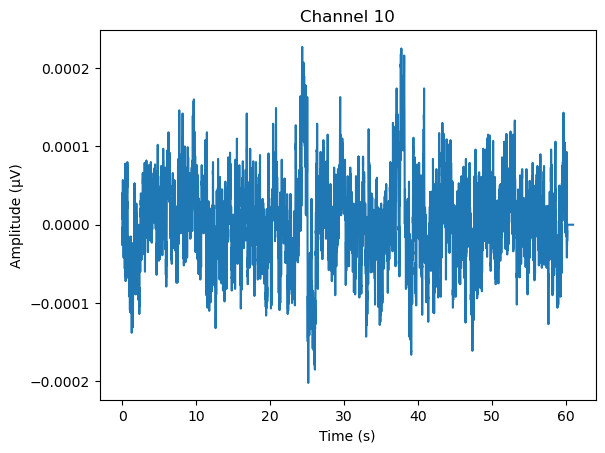

In [78]:
#This is the dataset for the eyes-open setting:
raw_1 = mne.io.read_raw_edf('S001R01.edf', preload = True)
print(raw_1.info)
data_1, times_1 = raw_1[:]

ch_index = 10  # pick a channel 
#plt.figure(figsize=(12,6))
plt.plot(times_1, data_1[ch_index, :])
plt.title(f"Channel {ch_index}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.show()

Extracting EDF parameters from /Users/aditya/Dropbox/Berkeley Teaching/153-248 Fall 2025/S001R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


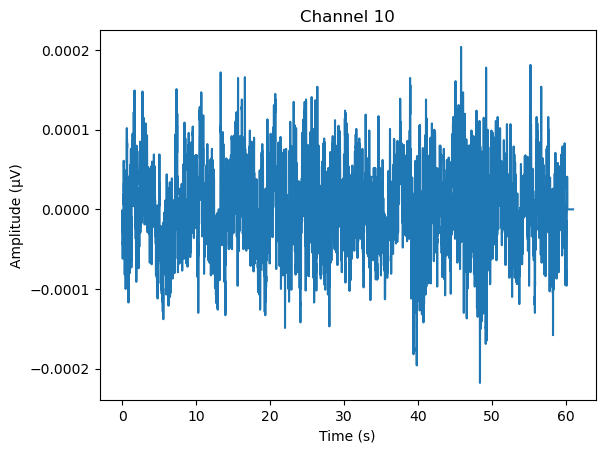

In [79]:
#Here is the dataset for the eyes closed setting. 
raw_2 = mne.io.read_raw_edf('S001R02.edf', preload = True)
print(raw_2.info)
data_2, times_2 = raw_2[:]

#plt.figure(figsize=(12,6))
plt.plot(times_2, data_2[ch_index, :])
plt.title(f"Channel {ch_index}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.show()

There is a sampling rate associated with these datasets. This is the number of times per second that the data is obtained. 

In [80]:
sampling_rate_1 = raw_1.info['sfreq']
print("Sampling rate:", sampling_rate_1, "Hz")
sampling_rate_2 = raw_2.info['sfreq']
print("Sampling rate:", sampling_rate_2, "Hz")
sampling_rate = sampling_rate_1


Sampling rate: 160.0 Hz
Sampling rate: 160.0 Hz


The length of these time series is 9760 (see below). This corresponds to 160 observations per second, for a total of 61 seconds. 

In [81]:
print(times_1)
print(times_2)
n = len(times_1)
print(n, n/sampling_rate) 

[0.000000e+00 6.250000e-03 1.250000e-02 ... 6.098125e+01 6.098750e+01
 6.099375e+01]
[0.000000e+00 6.250000e-03 1.250000e-02 ... 6.098125e+01 6.098750e+01
 6.099375e+01]
9760 61.0


Our two datasets are:

In [82]:
y_o = data_1[ch_index, :]
y_c = data_2[ch_index, :]

Our main goal is to compare these two datasets and to highlight the main ways in which they are different. 

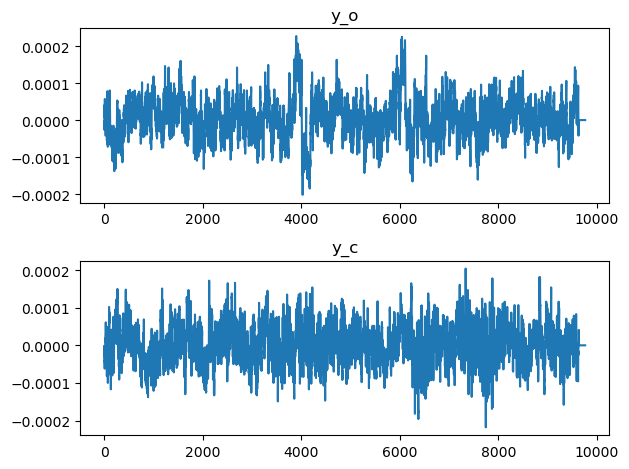

In [83]:
#fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))
fig, axes = plt.subplots(nrows = 2, ncols = 1)

axes[0].plot(y_o)
axes[0].set_title('y_o')

axes[1].plot(y_c)
axes[1].set_title('y_c')

plt.tight_layout()
plt.show()

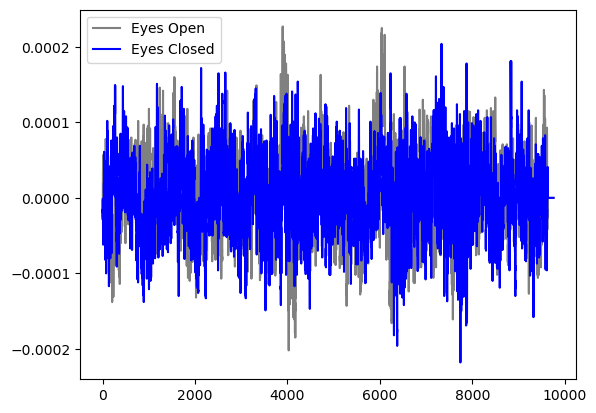

In [84]:
plt.plot(y_o, label = 'Eyes Open', color = 'gray')
plt.plot(y_c, label = 'Eyes Closed', color = 'blue')
plt.legend()
plt.show()


It is obviously very hard to articulate the differences between the two time series just by looking at their plots. For such datasets, the basic tool is the Periodogram. Recall that the periodogram is given by: 
\begin{align*}
   I(j/n) := \frac{|b_j|^2}{n}
\end{align*}
where $b_j$ is given by the Discrete Fourier Transform. We plot the periodogram when $j/n$ lies between 0 and $1/2$. 

In [85]:
def periodogram(y):
    fft_y = np.fft.fft(y)
    n = len(y)
    fourier_freqs = np.arange(1/n, 1/2, 1/n)
    m = len(fourier_freqs)
    pgram_y = (np.abs(fft_y[1:m+1]) ** 2)/n
    return fourier_freqs, pgram_y

In [86]:
n = len(y_o)
freqs, pgram_o = periodogram(y_o)
freqs, pgram_c = periodogram(y_c)


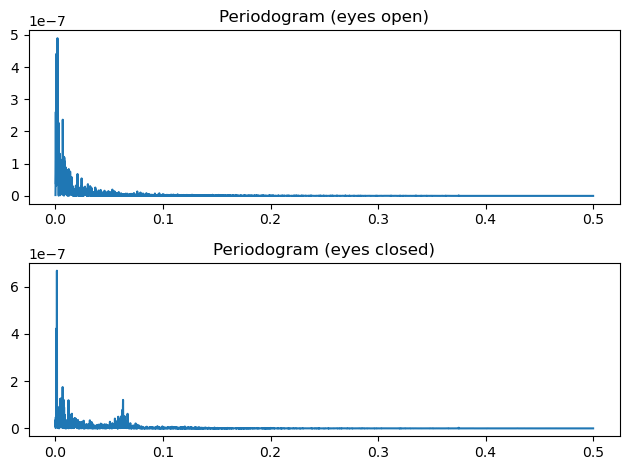

In [87]:
fig, axes = plt.subplots(nrows = 2, ncols = 1)

axes[0].plot(freqs, pgram_o)
axes[0].set_title('Periodogram (eyes open)')

axes[1].plot(freqs, pgram_c)
axes[1].set_title('Periodogram (eyes closed)')

plt.tight_layout()
plt.show()

The differences are more apparent from the periodograms. To see them better, we plot the periodograms on the log-scale. 

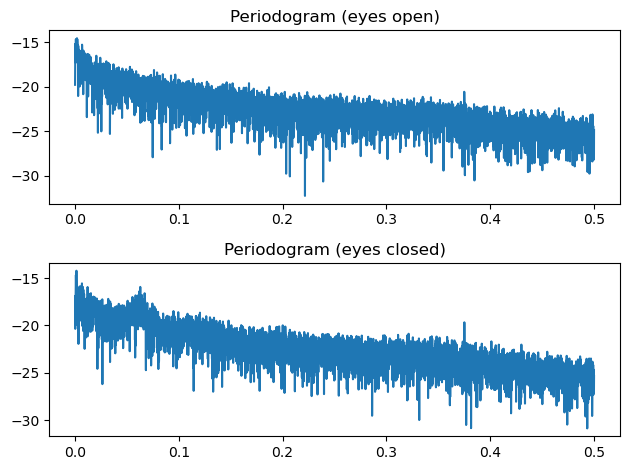

In [88]:
fig, axes = plt.subplots(nrows = 2, ncols = 1)

axes[0].plot(freqs, np.log(pgram_o))
axes[0].set_title('Periodogram (eyes open)')

axes[1].plot(freqs, np.log(pgram_c))
axes[1].set_title('Periodogram (eyes closed)')

plt.tight_layout()
plt.show()

Below we plot the log-periodograms in the same plot. 

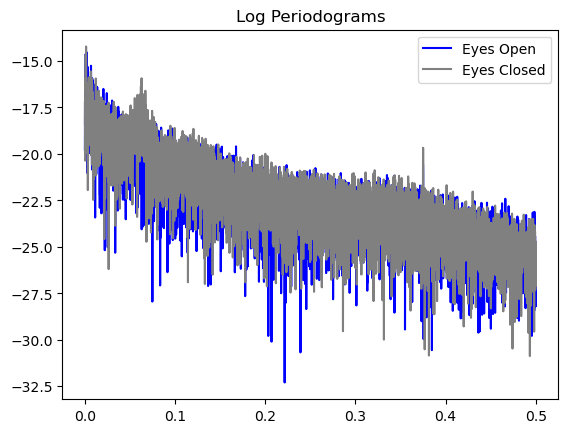

In [89]:

plt.plot(freqs, np.log(pgram_o), label = 'Eyes Open', color = 'blue')
plt.plot(freqs, np.log(pgram_c), label = 'Eyes Closed', color = 'gray')
plt.title('Log Periodograms')
plt.legend()
plt.show()


To visualize the differences better, we need to smooth the log-periodogram somehow. This is where our model 3 is helpful. 

### Model 3 (Spectrum Model)

Model 3 is
\begin{equation*}
    \text{Re}(b_j), \text{Im}(b_j) \overset{\text{i.i.d}}{\sim} N(0, \gamma_j^2)
\end{equation*}
for $j = 1, \dots, m$ where $b_j$ is the $j^{th}$ DFT coefficient of the observed data $y_1, \dots, y_n$. 

Likelihood in terms of the periodogram is: 
\begin{equation*}
   \prod_{j=1}^m \frac{n}{\gamma_j^2} \exp \left(-\frac{n I(j/n)}{2 \gamma_j^2} \right)
\end{equation*}
Negative log-likelihood is
\begin{equation*}
  \sum_{j=1}^m \left(\frac{n I(j/n)}{2 \gamma_j^2} +  2 \log \gamma_j \right)
\end{equation*}
Letting $\alpha_j = \log \gamma_j$, we can rewrite the above as
\begin{equation*}
\sum_{j=1}^m \left( \frac{nI(j/n)}{2} e^{-2 \alpha_j} + 2 \alpha_j \right)
\end{equation*}
Minimizing this without any regularization on $\{\alpha_j\}$ leads to
\begin{equation*}
    \alpha_j = \log \sqrt{\frac{nI(j/n)}{2}} ~~ \text{ and } ~~ \gamma_j^2 = e^{2\alpha_j} = \frac{nI(j/n)}{2}
\end{equation*}
We will use regularization and estimate $\alpha_j$ (and $\gamma_j$) by minimizing:
\begin{equation*}
   \sum_{j=1}^m \left( \frac{nI(j/n)}{2} e^{-2 \alpha_j} + 2 \alpha_j \right)  + \lambda \sum_{j=2}^{m-1} \left((\alpha_{j+1} - \alpha_j) - (\alpha_j - \alpha_{j-1}) \right)^2
\end{equation*}
or
\begin{equation*}
    \sum_{j=1}^m \left( \frac{nI(j/n)}{2} e^{-2 \alpha_j} + 2 \alpha_j \right) + \lambda \sum_{j=2}^{m-1} \left|(\alpha_{j+1} - \alpha_j) - (\alpha_j - \alpha_{j-1}) \right|.
\end{equation*}
Code for computing these estimators is given below. These functions (alpha_estimator_ridge and alpha_estimator_lasso) use $y$ and $\lambda$ as input. In the first step, one computes the periodogram $I(j/n)$ as the optimization is in terms of the periodogram. We apply these methods to the EEG dataset.

In [96]:
def alpha_estimator_ridge(y, lambda_val):
    freq, I = periodogram(y)
    m = len(freq)
    n = len(y)
    alpha = cp.Variable(m)
    neg_likelihood_term = cp.sum(cp.multiply((n * I / 2), cp.exp(-2 * alpha)) + 2*alpha)
    smoothness_penalty = cp.sum(cp.square(alpha[2:] - 2 * alpha[1:-1] + alpha[:-2]))
    objective = cp.Minimize(neg_likelihood_term + lambda_val * smoothness_penalty)
    problem = cp.Problem(objective)
    problem.solve(solver = cp.MOSEK)
    return alpha.value, freq

def alpha_estimator_lasso(y, lambda_val):
    freq, I = periodogram(y)
    m = len(freq)
    n = len(y) 
    alpha = cp.Variable(m)
    neg_likelihood_term = cp.sum(cp.multiply((n * I / 2), cp.exp(-2 * alpha)) + 2*alpha)
    smoothness_penalty = cp.sum(cp.abs(alpha[2:] - 2 * alpha[1:-1] + alpha[:-2]))
    objective = cp.Minimize(neg_likelihood_term + lambda_val * smoothness_penalty)
    problem = cp.Problem(objective)
    problem.solve(solver = cp.MOSEK)
    return alpha.value, freq

We will now apply these estimators to each of the two datasets (eyes open and eyes closed). We compute estimates of $\alpha_j, j = 1, \dots, m$ and also compute the corresponding $2 \gamma_j^2/n$ (where $\gamma_j = \exp(\alpha_j)$). This quantity $2 \gamma_j^2/n$ equals the mean of $I(j/n)$ in our model $I(j/n) \sim \frac{\gamma_j^2}{n} \chi^2_2$. 

In [106]:
#Eyes Open
alpha_opt_ridge_o, freq = alpha_estimator_ridge(y_o, 50000000)
pgram_mean_ridge_o = (2/n)*(np.exp(2*alpha_opt_ridge_o))
alpha_opt_lasso_o, freq = alpha_estimator_lasso(y_o, 1000)
pgram_mean_lasso_o = (2/n)*(np.exp(2*alpha_opt_lasso_o))

#Eyes Closed
alpha_opt_ridge_c, freq = alpha_estimator_ridge(y_c, 50000000)
pgram_mean_ridge_c = (2/n)*(np.exp(2*alpha_opt_ridge_c))
alpha_opt_lasso_c, freq = alpha_estimator_lasso(y_c, 1000)
pgram_mean_lasso_c = (2/n)*(np.exp(2*alpha_opt_lasso_c))


Below we plot the periodogram and its mean $2 \gamma_j^2/n$ both on log-scale. 

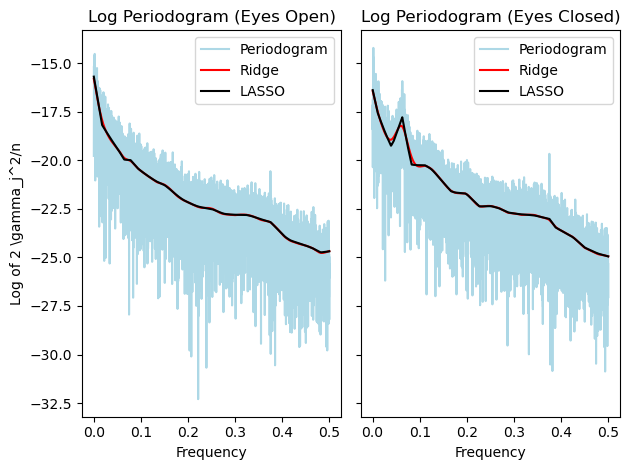

In [111]:
fig, axes = plt.subplots(1, 2, sharey=True)

# ----- Left subplot: Eyes Open -----
axes[0].plot(freqs, np.log(pgram_o), color='lightblue', label='Periodogram')
axes[0].plot(freqs, np.log(pgram_mean_ridge_o), color='red', label='Ridge')
axes[0].plot(freqs, np.log(pgram_mean_lasso_o), color='black', label='LASSO')
axes[0].set_title('Log Periodogram (Eyes Open)')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Log of 2 \gamma_j^2/n')
axes[0].legend()

# ----- Right subplot: Eyes Closed -----
axes[1].plot(freqs, np.log(pgram_c), color='lightblue', label='Periodogram')
axes[1].plot(freqs, np.log(pgram_mean_ridge_c), color='red', label='Ridge')
axes[1].plot(freqs, np.log(pgram_mean_lasso_c), color='black', label='LASSO')
axes[1].set_title('Log Periodogram (Eyes Closed)')
axes[1].set_xlabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

Below we plot the estimated $2 \gamma_j^2/n$ (on the log-scale). These should be viewed as smoothed versions of the respective periodograms.  

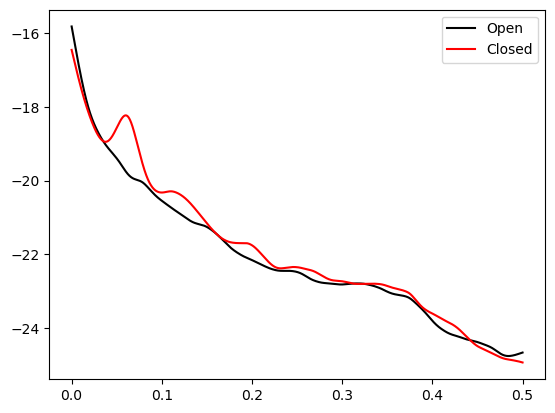

In [ ]:
plt.plot(freqs, np.log(pgram_mean_ridge_o), color = 'black', label = 'Open')
plt.plot(freqs, np.log(pgram_mean_ridge_c), color = 'red', label = 'Closed')
plt.legend()
plt.show()

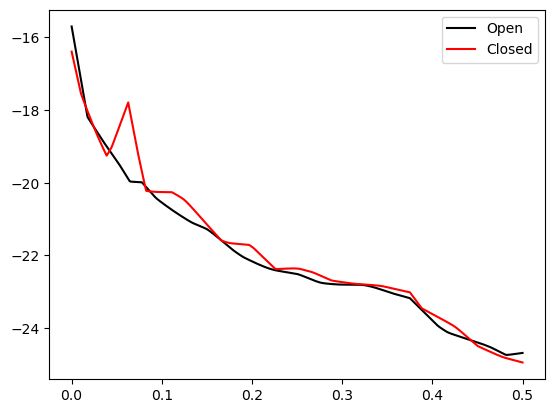

In [ ]:

plt.plot(freqs, np.log(pgram_mean_lasso_o), color = 'black', label = 'Open')
plt.plot(freqs, np.log(pgram_mean_lasso_c), color = 'red', label = 'Closed')
plt.legend()
plt.show()

The peak in the 'eyes closed' curve above can be computed as follows. 

In [112]:
from scipy.signal import find_peaks
# Find peaks
peaks, _ = find_peaks(np.log(pgram_mean_lasso_c))
print(peaks/n)


[0.06270492 0.1079918  0.24518443]


The peak corresponds to the frequency $0.06270492$. To convert the frequency to Hertz, we multiply it by the sampling rate. 

In [95]:
(peaks[0]/n) * sampling_rate


10.032786885245901

So the differences between the two smoothed periodogram estimates is mainly at frequency 10.0328 Hz. This is very close to the 10Hz Alpha rhythm which apparently exists when eyes are closed as opposed to eyes being open (see, for example, the first sentence in this paper "Occipital alpha-band brain waves when the eyes are closed are shaped by ongoing visual processes" by Hohaia et al 2022). The wiki page on the alpha wave (see https://en.wikipedia.org/wiki/Alpha_wave) says that alpha waves are neural oscillations in the frequency range 8-12 Hz. We can see from the plot above that at 8 - 12 Hz, the estimated spectrum for the closed eyes data is higher than the spectrm for open eyes data. 

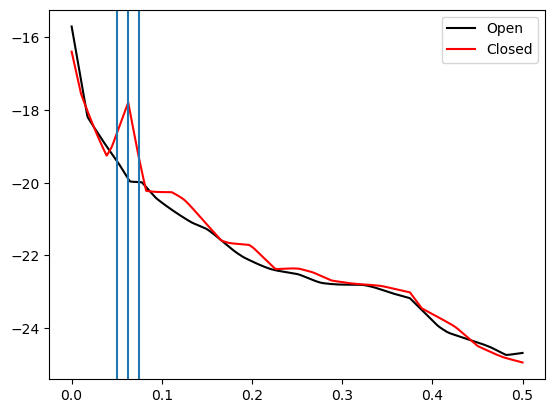

In [113]:
#Estimated power spectra
plt.plot(freqs, np.log(pgram_mean_lasso_o), color = 'black', label = 'Open')
plt.plot(freqs, np.log(pgram_mean_lasso_c), color = 'red', label = 'Closed')
plt.axvline(x = 10/sampling_rate)
plt.axvline(x = 8/sampling_rate)
plt.axvline(x = 12/sampling_rate)
plt.legend()
plt.show()